# Step 1: Creating a graph in DGL

In [1]:
import torch
import dgl

In [5]:
def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)
    return g

In [6]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())


We have 34 nodes.
We have 156 edges.


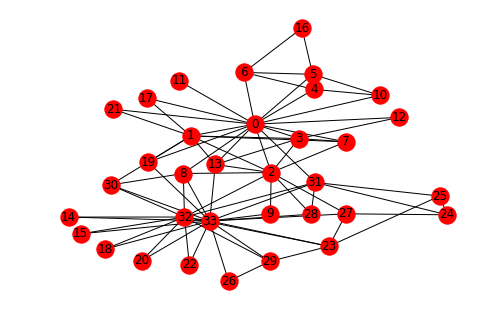

In [8]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

# Step 2: assign features to nodes or edges

In [9]:
torch.eye(34)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [10]:
G.ndata['feat'] = torch.eye(34)

In [11]:
G.nodes[2].data

{'feat': tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}

In [12]:
G.nodes[2].data['feat']

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Step 3: define a Graph Convolutional Network (GCN)
原論文
https://arxiv.org/pdf/1609.02907.pdf
<img src="https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/mailbox.png" alt="Drawing" style="width: 400px;"/>


In [13]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)


In [17]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

# Step 4: data preparation and initialization

- 各ノードの特徴量はone-hotベクトルで初期化
- インストラクター(node 0)とクラブ会長(node 33)にだけ、それぞれ(0, 1)のラベルを与える。
- 半教師あり学習

In [14]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

# Step 5: train then visualize

### Pytorchモデルの学習の流れ
- create an optimizer
- feed the inputs to the model
- calculate the loss
- use autograd to optimize the model

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    # F: torch.nn.functional
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

/Users/suzukitarou/env_default/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0 | Loss: 0.8403
Epoch 1 | Loss: 0.7442
Epoch 2 | Loss: 0.6695
Epoch 3 | Loss: 0.6038
Epoch 4 | Loss: 0.5504
Epoch 5 | Loss: 0.5031
Epoch 6 | Loss: 0.4563
Epoch 7 | Loss: 0.4071
Epoch 8 | Loss: 0.3575
Epoch 9 | Loss: 0.3097
Epoch 10 | Loss: 0.2705
Epoch 11 | Loss: 0.2380
Epoch 12 | Loss: 0.2107
Epoch 13 | Loss: 0.1860
Epoch 14 | Loss: 0.1623
Epoch 15 | Loss: 0.1347
Epoch 16 | Loss: 0.1058
Epoch 17 | Loss: 0.0786
Epoch 18 | Loss: 0.0556
Epoch 19 | Loss: 0.0378
Epoch 20 | Loss: 0.0249
Epoch 21 | Loss: 0.0161
Epoch 22 | Loss: 0.0104
Epoch 23 | Loss: 0.0068
Epoch 24 | Loss: 0.0046
Epoch 25 | Loss: 0.0032
Epoch 26 | Loss: 0.0024
Epoch 27 | Loss: 0.0018
Epoch 28 | Loss: 0.0015
Epoch 29 | Loss: 0.0013


toy exampleなのでvalidationやtestはできない代わりにvisualizeしてみよう

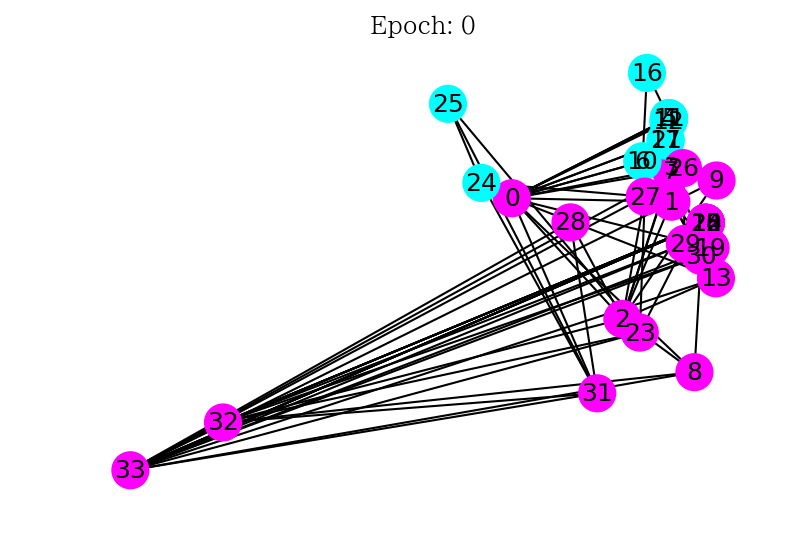

In [21]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch

<IPython.core.display.Javascript object>


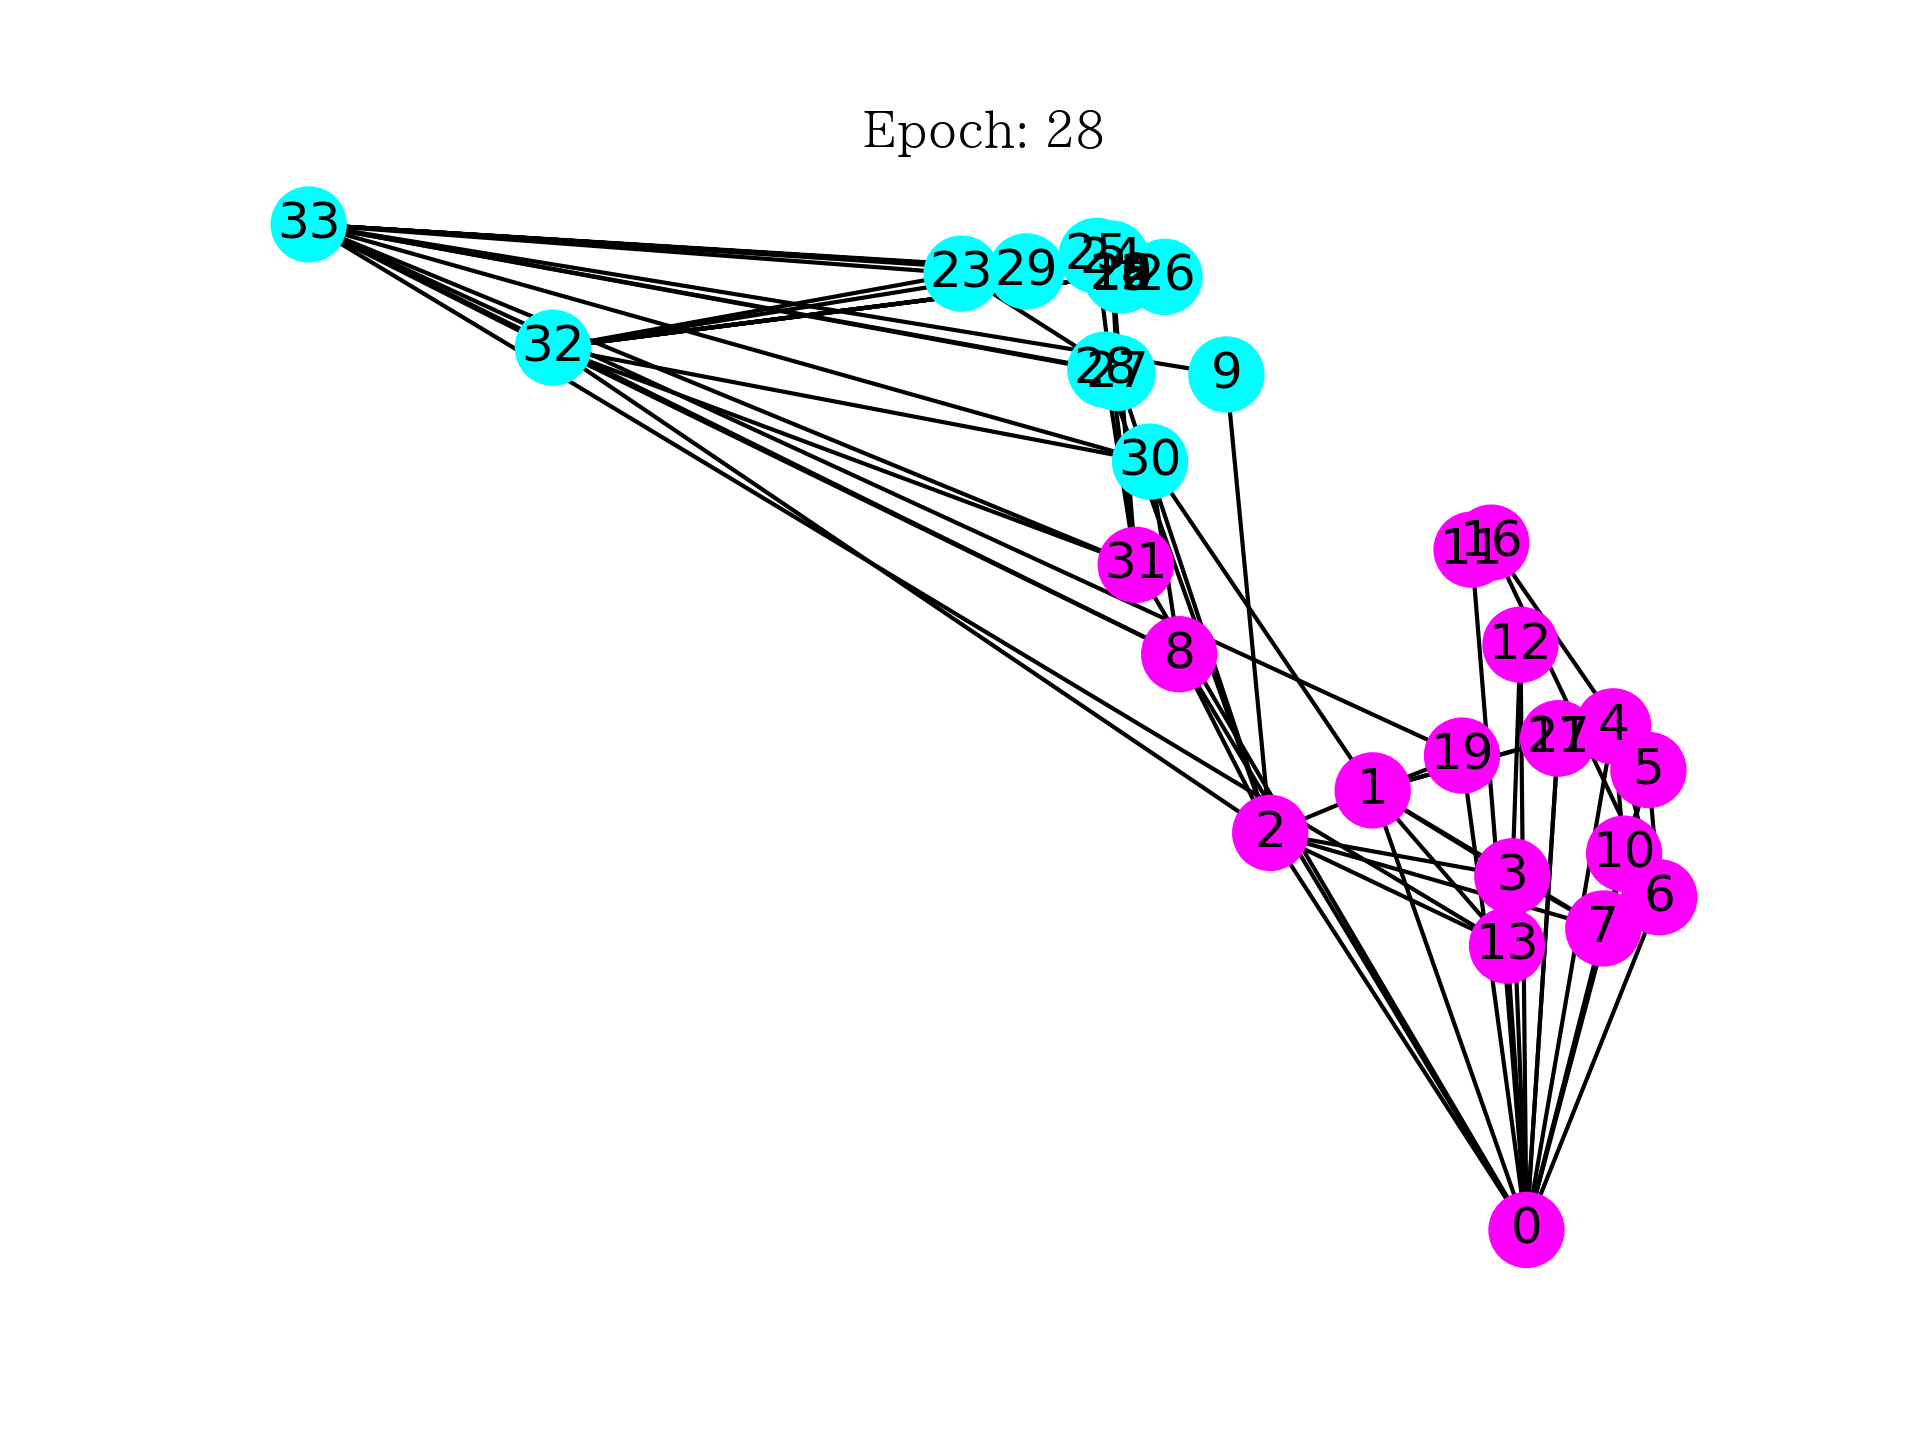

In [33]:
%matplotlib nbagg

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
plt.show()